In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from datasets import load_metric, Dataset
import datasets
import torch
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EvalPrediction

In [18]:
#device = 'cuda' if cuda.is_available() else 'cpu'
device = 'cpu'
print(device)

cpu


Метрики для модели

In [6]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

Подготовка текстов документов для подачи в модель

In [16]:
# словари для перевода лейблов в числа для модели
labels = [label for label in train.columns if label not in ['text']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

#для трейна
def preprocess_data(examples):
    # take a batch of texts
    text = examples['text']
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512) #max_length=128
    
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()
  
    return encoding

def encoding_dataset(df_train, test_size=0.2):
    #подготовка датасета для модели
    #features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels']
    train_df, valid_df = train_test_split(df_train, test_size=test_size, random_state=42)
    train_dataset = Dataset.from_pandas(train_df)
    valid_dataset = Dataset.from_pandas(valid_df)
    dataset = datasets.DatasetDict({"train":train_dataset,
                                    "validation":valid_dataset,
                                    #'test': test_dataset
                                   })
    
    encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)
    encoded_dataset.set_format("torch")
    
    return encoded_dataset#, labels, id2label, label2id

#длятеста
def preprocess_test(examples):
    # take a batch of texts
    text = examples['texts']
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512) #max_length=128
  
    return encoding

def encoding_test(df_test):
    #подготовка датасета для модели
    #features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels']
    test_dataset = Dataset.from_pandas(df_test)
    dataset = datasets.DatasetDict({"test":test_dataset})
    
    encoded_dataset = dataset.map(preprocess_test, batched=True, remove_columns=dataset['test'].column_names)
    encoded_dataset.set_format("torch")
    
    return encoded_dataset

Предсказание для для датасета и для отдельного текста

In [26]:
def predict_text(text):
    #предсказание для одного текста
    encoding = tokenizer(text, return_tensors="pt")
    encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

    outputs = trainer.model(**encoding)
    logits = outputs.logits
    # apply sigmoid + threshold
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits.squeeze().to("cpu"))
    predictions = np.zeros(probs.shape)
    #predictions[np.where(probs >= 0.5)] = 1  #мультилейбл
    predictions[np.where(probs == max(probs))] = 1  #один лейбл
    # turn predicted id's into actual label names
    predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
    return predicted_labels

def get_prediction(dataset):
    # предсказание для теста
    pred = trainer.predict(dataset)
    predict = pred.predictions
    labels = np.argmax(predict, axis = -1)
    score = np.max(predict, axis = -1)
    labels = [id2label[idx] for idx in list(labels)]
    return labels, score

Загрузка датасета

In [9]:
train = pd.read_csv('dataset/train.csv', sep=',', index_col=None)
train.head()

,class,text
0,contract,"Приложение к письму Банка России ""О форме дого..."
1,contract,ДОГОВОР МЕЖДУ РОССИЙСКОЙ ФЕДЕРАЦИЕЙ И РЕСПУБЛИ...
2,contract,"Договор {ДатаДокумента} г. {НазваниеКонтр}, в ..."
3,contract,"ДОГОВОР г. Москва 2020 года Гр. РФ , года рожд..."
4,contract,Зарегистрировано в Минюсте РФ 25 августа 1992 ...


Проверка количества записей по классам

In [10]:
train['class'].value_counts()

class
arrangement       323
order             309
contract          296
application        72
proxy              71
act                69
determination      58
statute            50
invoice            43
bill               41
contract offer     26
Name: count, dtype: int64

Проверка длины текстов для определения оптимальной длины последовательности токенов, чтобы избежать разреженных векторов.

In [11]:
#максимальная длина документа
seq_len_train = [len(str(i).split()) for i in train['text']]
max_seq_len = max(seq_len_train)
#если меньше 512 tokenizer(max_length) уменьшить,чтоб не было пустоты
max_seq_len

35947

<Axes: >

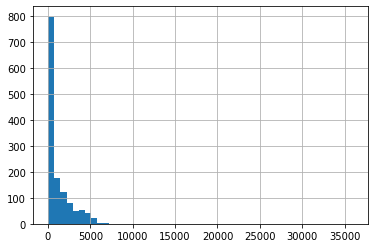

In [12]:
seq_len = [len(str(i).split()) for i in train['text']]
pd.Series(seq_len).hist(bins = 50)

Подготовка лейблов для модели

In [13]:
train = pd.get_dummies(train, columns=['class'], prefix='', prefix_sep='', dtype=bool, drop_first= False)
train.head()

,text,act,application,arrangement,bill,contract,contract offer,determination,invoice,order,proxy,statute
0,"Приложение к письму Банка России ""О форме дого...",False,False,False,False,True,False,False,False,False,False,False
1,ДОГОВОР МЕЖДУ РОССИЙСКОЙ ФЕДЕРАЦИЕЙ И РЕСПУБЛИ...,False,False,False,False,True,False,False,False,False,False,False
2,"Договор {ДатаДокумента} г. {НазваниеКонтр}, в ...",False,False,False,False,True,False,False,False,False,False,False
3,"ДОГОВОР г. Москва 2020 года Гр. РФ , года рожд...",False,False,False,False,True,False,False,False,False,False,False
4,Зарегистрировано в Минюсте РФ 25 августа 1992 ...,False,False,False,False,True,False,False,False,False,False,False


In [14]:
labels = [label for label in train.columns if label not in ['text']]
labels

['act',
 'application',
 'arrangement',
 'bill',
 'contract',
 'contract offer',
 'determination',
 'invoice',
 'order',
 'proxy',
 'statute']

Разделение датасета на тренировочный и валидационный в соотношении 80/20

In [12]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
#test_dataset = Dataset.from_pandas(df_test.reset_index())

In [16]:
encoded_dataset = encoding_dataset(train, test_size=0.2)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [17]:
#пример для проверки
i=0
example = encoded_dataset['train'][i]
print(example.keys())
print(example['labels'])
print([id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0])
print(tokenizer.decode(example['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
['arrangement']
[CLS] Дополнительное соглашение № 47 к трудовому договору № 12 - ТД от " 30 " марта 2015 года об отмене дистанционной работы г. Киров " 10 " сентября 2020 года Общество с ограниченной ответственностью " Астра " ( ООО " Астра " ), именуемое в дальнейшем " Работодатель ", в лице генерального директора Ложкина Петра Петровича, действующего на основании Устава, с одной стороны, и дизайнер Соколов Илья Ильич, именуемый в дальнейшем " Работник ", с другой стороны, вместе именуемые " Стороны ", заключили настоящее дополнительное соглашение к трудовому договору № 12 - ТД от " 30 " марта 2015 года о нижеследующем : 1. П. 2 трудового договора изложить в следующей редакции : " Работник выполняет трудовую функцию по месту нахождения работодателя : г. Киров, ул. Некрасова, д. 87, оф. 11Б. Начало рабочего дня – в 8 : 00, окончание – в 17 : 00. Обеденный перерыв 

Определение модели

In [20]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased-sentence',
                                                      problem_type="multi_label_classification", 
                                                      num_labels=len(labels),
                                                      id2label=id2label,
                                                      label2id=label2id).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Транировка модели

In [19]:
batch_size = 1  #больше 2 ухудшают результат до случайного
metric_name = "f1"

args = TrainingArguments(
    output_dir = "training/results",        #Выходной каталог
    evaluation_strategy = "epoch",          #Валидация после каждой эпохи (можно после конкретного кол-ва шагов)
    save_strategy = "epoch",                #Сохранение после каждой эпохи
    learning_rate=1e-5,                     #Скорость обучения 1e-5 = 0,00001 
    per_device_train_batch_size=batch_size, #Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size=batch_size,  #Размер пакета для каждого устройства во время валидации
    num_train_epochs=5,                     #Кол-во эпох для обучения
    weight_decay=0.01,                      #Понижение весов
    load_best_model_at_end=True,            #Загружать ли лучшую модель после обучения
    metric_for_best_model=metric_name,
    save_total_limit = 1,
    seed=42,
    #logging_dir = 'training/logs',         #Каталог для хранения журналов
    #logging_strategy = 'epoch',            #Логирование после каждой эпохи
    #push_to_hub=False,
    report_to="none"                        #wandb отключить
)

In [20]:
#forward pass
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), 
                labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


SequenceClassifierOutput(loss=tensor(0.7018, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.4027, -0.1046, -0.1016,  0.0463,  0.0905, -0.1218,  0.0214,  0.4044,
          0.1010, -0.0374, -0.0027]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [21]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.130700,0.106010,0.800000,0.843750,0.691176
2,0.071200,0.061636,0.942748,0.953125,0.908088
3,0.038100,0.040956,0.958955,0.971140,0.944853
4,0.023400,0.035117,0.957328,0.972610,0.948529
5,0.016900,0.028249,0.970260,0.978860,0.959559


TrainOutput(global_step=5430, training_loss=0.06846426450964715, metrics={'train_runtime': 881.5598, 'train_samples_per_second': 6.16, 'train_steps_per_second': 6.16, 'total_flos': 1428808479528960.0, 'train_loss': 0.06846426450964715, 'epoch': 5.0})

Валидация

In [23]:
# встроенная валидаци
trainer.evaluate()

{'eval_loss': 0.028248809278011322,
 'eval_f1': 0.9702602230483273,
 'eval_roc_auc': 0.9788602941176471,
 'eval_accuracy': 0.9595588235294118,
 'eval_runtime': 9.714,
 'eval_samples_per_second': 28.001,
 'eval_steps_per_second': 28.001,
 'epoch': 5.0}

In [34]:
#валидация sklern
pred, score = get_prediction(encoded_dataset["validation"])
test_labels = np.argmax(encoded_dataset['validation']['labels'], axis = -1) #тестовые лейблы в цифры
test_labels = [id2label[idx] for idx in list(np.array(test_labels))]
print(classification_report(test_labels, pred))
print(f1_score(test_labels, pred, average='micro'))

                precision    recall  f1-score   support

           act       1.00      1.00      1.00        12
   application       0.95      0.95      0.95        19
   arrangement       1.00      0.98      0.99        63
          bill       1.00      1.00      1.00        11
      contract       0.93      1.00      0.96        55
contract offer       1.00      0.43      0.60         7
 determination       0.82      1.00      0.90        14
       invoice       1.00      0.86      0.92         7
         order       1.00      1.00      1.00        59
         proxy       1.00      1.00      1.00        11
       statute       1.00      0.93      0.96        14

      accuracy                           0.97       272
     macro avg       0.97      0.92      0.94       272
  weighted avg       0.97      0.97      0.97       272

0.9705882352941176


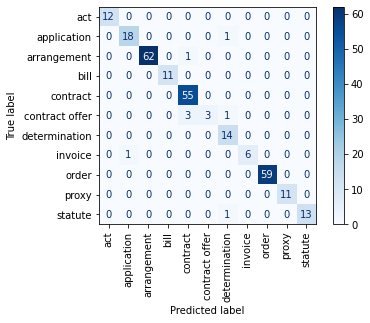

In [35]:
ConfusionMatrixDisplay.from_predictions(test_labels, pred, xticks_rotation = 'vertical', cmap=plt.cm.Blues)
plt.show()

Загрузка сохраненной модели для проверки

In [36]:
save_directory = 'training/results/checkpoint-5430'
best_model = BertForSequenceClassification.from_pretrained(save_directory, local_files_only=True)#, return_dict=True

In [37]:
trainer1 = Trainer(best_model)

In [38]:
def get_prediction1(dataset):
    # предсказание для проверки загрузки сохраненной модели
    pred = trainer1.predict(dataset)
    labels = np.argmax(pred.predictions, axis = -1)
    labels = [id2label[idx] for idx in list(labels)]
    return labels

In [39]:
#валидация
pred = get_prediction1(encoded_dataset["validation"])
test_labels = np.argmax(encoded_dataset['validation']['labels'], axis = -1) #тестовые лейблы в цифры
test_labels = [id2label[idx] for idx in list(np.array(test_labels))]
print(classification_report(test_labels, pred))
print(f1_score(test_labels, pred, average='micro'))

                precision    recall  f1-score   support

           act       1.00      1.00      1.00        12
   application       0.95      0.95      0.95        19
   arrangement       1.00      0.98      0.99        63
          bill       1.00      1.00      1.00        11
      contract       0.93      1.00      0.96        55
contract offer       1.00      0.43      0.60         7
 determination       0.82      1.00      0.90        14
       invoice       1.00      0.86      0.92         7
         order       1.00      1.00      1.00        59
         proxy       1.00      1.00      1.00        11
       statute       1.00      0.93      0.96        14

      accuracy                           0.97       272
     macro avg       0.97      0.92      0.94       272
  weighted avg       0.97      0.97      0.97       272

0.9705882352941176
